<a href="https://colab.research.google.com/github/VsLee-enf/toss-place_analysis/blob/master/Colab-tossplace_analysis0914.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# =======================================================
# 1단계: 드라이브 마운트 및 데이터 로딩 (오류 수정)
# =======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os # os 모듈 추가
from google.colab import drive

# --- 1. 환경 설정 ---
warnings.filterwarnings('ignore')

# Colab 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 폰트 설치 후 런타임을 다시 시작해야 합니다.
# 런타임 > 런타임 다시 시작 을 클릭해주세요.
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
print("✅ Colab 환경 설정 완료")

# --- 2. Google 드라이브 마운트 ---
drive.mount('/content/drive')
print("\n✅ Google 드라이브 마운트 완료")

# --- 3. 데이터 로딩 (인코딩 및 파일 경로 문제 해결) ---
# ⚠️ 아래 파일 경로를 본인의 Google 드라이브 경로에 맞게 다시 한번 확인해주세요!
# G: 드라이브 경로는 Google Colab에서 직접 사용할 수 없습니다.
# "/content/drive/My Drive/" 로 시작하는 경로를 사용해야 합니다.

# 예시: public_data_path_str = "/content/drive/My Drive/python/Sesac/최종 프로젝트/파이썬파일_01/data/서울시 상권분석서비스(추정매출-행정동).csv"
# 예시: activity_data_path_str = "/content/drive/My Drive/python/Sesac/최종 프로젝트/파이썬파일_01/data/virtual_activity_data.csv"

# 실제 Google Drive 경로를 입력해주세요.
public_data_base_path = "/content/drive/My Drive/python/Sesac/최종 프로젝트/파이썬파일_01/data"
public_data_filename = "서울시 상권분석서비스(추정매출-행정동).csv"
activity_data_filename = "virtual_activity_data.csv" # 이 파일이 실제로 존재하는지 확인해주세요.

public_data_path = os.path.join(public_data_base_path, public_data_filename)
activity_data_path = os.path.join(public_data_base_path, activity_data_filename)


commercial_data = None
activity_data = None

# 안정적인 파일 로딩 (utf-8 먼저 시도)
try:
    commercial_data = pd.read_csv(public_data_path, encoding='utf-8')
    print("✅ 공공데이터 로딩 완료 (utf-8 인코딩)")
except FileNotFoundError:
    print(f"❌ 파일 로딩 실패: {public_data_path} 경로에 파일이 없습니다.")
except UnicodeDecodeError:
    try:
        commercial_data = pd.read_csv(public_data_path, encoding='cp949')
        print("✅ 공공데이터 로딩 완료 (cp949 인코딩)")
    except FileNotFoundError:
        print(f"❌ 파일 로딩 실패: {public_data_path} 경로에 파일이 없습니다.")
    except Exception as e:
        print(f"❌ 공공데이터 로딩 실패: {e}")
except Exception as e:
    print(f"❌ 공공데이터 로딩 실패: {e}")


try:
    activity_data = pd.read_csv(activity_data_path, encoding='utf-8')
    print("✅ 활동데이터 로딩 완료 (utf-8 인코딩)")
except FileNotFoundError:
    print(f"❌ 파일 로딩 실패: {activity_data_path} 경로에 파일이 없습니다.")
except UnicodeDecodeError:
    try:
        activity_data = pd.read_csv(activity_data_path, encoding='cp949')
        print("✅ 활동데이터 로딩 완료 (cp949 인코딩)")
    except FileNotFoundError:
        print(f"❌ 파일 로딩 실패: {activity_data_path} 경로에 파일이 없습니다.")
    except Exception as e:
        print(f"❌ 활동데이터 로딩 실패: {e}")
except Exception as e:
    print(f"❌ 활동데이터 로딩 실패: {e}")


# --- 4. 데이터 병합 및 분석 데이터셋 준비 ---
if commercial_data is not None and activity_data is not None:
    print("\n🔄 데이터 병합 및 분석 준비 중...")

    # commercial_data의 행정동별 매출 데이터를 집계 (중복 제거)
    # '행정동_코드_명' 컬럼이 존재한다고 가정하고 집계
    if '행정동_코드_명' in commercial_data.columns:
        numeric_cols = commercial_data.select_dtypes(include=np.number).columns.drop(['기준_년분기_코드', '행정동_코드'], errors='ignore')
        commercial_agg = commercial_data.groupby(['행정동_코드', '행정동_코드_명'])[numeric_cols].sum().reset_index()

        # activity_data와 병합
        # activity_data에 '행정동명' 컬럼이 존재한다고 가정하고 병합
        if '행정동명' in activity_data.columns:
             df_merged = pd.merge(commercial_agg, activity_data, left_on='행정동_코드_명', right_on='행정동명', how='inner')
             print(f"✅ 데이터 병합 완료. 최종 분석 데이터 형태: {df_merged.shape}")

             # 4-1. 올바른 목표 변수(y) 설정
             # '상권회전율' 컬럼이 병합된 데이터에 존재한다고 가정
             if '상권회전율' in df_merged.columns:
                 target_variable = '상권회전율'
                 y = df_merged[target_variable]
                 print(f"🎯 목표 변수(y)를 실제 데이터인 '{target_variable}'로 설정했습니다.")

                 # 4-2. 분석 변수(X) 정의
                 features_to_exclude = [
                     '상권회전율', '창업률', '폐업률', '신규창업수', '폐업수',
                     '행정동_코드', '행정동_코드_명', '년월', '행정동명'
                 ]
                 X = df_merged.select_dtypes(include=np.number).drop(columns=features_to_exclude, errors='ignore')
                 X = X.fillna(0)

                 print(f"✅ 분석에 사용될 특성(X) 개수: {X.shape[1]}개")

                 # --- 5. 데이터 기본 정보 확인 ---
                 print("\n--- 최종 통합 데이터 정보 (상위 5개) ---")
                 display(df_merged.head())
                 print("\n--- 분석 특성(X) 샘플 ---")
                 display(X.head())
             else:
                 print("\n⚠️ 병합된 데이터에 '상권회전율' 컬럼이 없어 분석을 진행할 수 없습니다. 데이터 파일을 확인해주세요.")
        else:
            print("\n⚠️ 활동 데이터에 '행정동명' 컬럼이 없어 데이터 병합을 진행할 수 없습니다. 활동 데이터 파일을 확인해주세요.")
    else:
        print("\n⚠️ 공공 데이터에 '행정동_코드_명' 컬럼이 없어 데이터 집계를 진행할 수 없습니다. 공공 데이터 파일을 확인해주세요.")
else:
    print("\n⚠️ 데이터 로딩에 실패하여 다음 단계를 진행할 수 없습니다. 파일 경로와 파일이 드라이브에 올바르게 있는지 확인해주세요.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

,행정동_코드,행정동_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,...,여성매출비율,총점포수,업종다양성지수,평균객단가,거래변동성,유동인구,임대료수준,교통접근성,신규창업수,폐업수
0,11140550,명동,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,...,0.632,605,0.879,34251,8.2,215116,14336,5.6,17,16
1,11140550,명동,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,...,0.577,544,0.950,36209,10.4,230859,14859,7.4,16,15
2,11140550,명동,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,...,0.497,559,0.950,38196,6.3,233492,14256,6.5,14,11
3,11140550,명동,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,...,0.506,533,0.950,40867,7.5,222923,14703,6.7,17,9
4,11140550,명동,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,...,0.521,558,0.950,30445,9.3,228911,15000,6.7,18,14



--- 분석 특성(X) 샘플 ---


,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,...,주중매출비율,젊은층매출비율,여성매출비율,총점포수,업종다양성지수,평균객단가,거래변동성,유동인구,임대료수준,교통접근성
0,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,213299125527,140816571891,...,0.660,0.504,0.632,605,0.879,34251,8.2,215116,14336,5.6
1,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,213299125527,140816571891,...,0.631,0.411,0.577,544,0.950,36209,10.4,230859,14859,7.4
2,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,213299125527,140816571891,...,0.551,0.442,0.497,559,0.950,38196,6.3,233492,14256,6.5
3,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,213299125527,140816571891,...,0.564,0.501,0.506,533,0.950,40867,7.5,222923,14703,6.7
4,1217567870416,53717988,984404683952,233163186464,188290846010,197252478915,188672056562,196890176938,213299125527,140816571891,...,0.595,0.405,0.521,558,0.950,30445,9.3,228911,15000,6.7


🔄 2단계 분석 시작: 데이터 탐색 및 다중공선성 진단


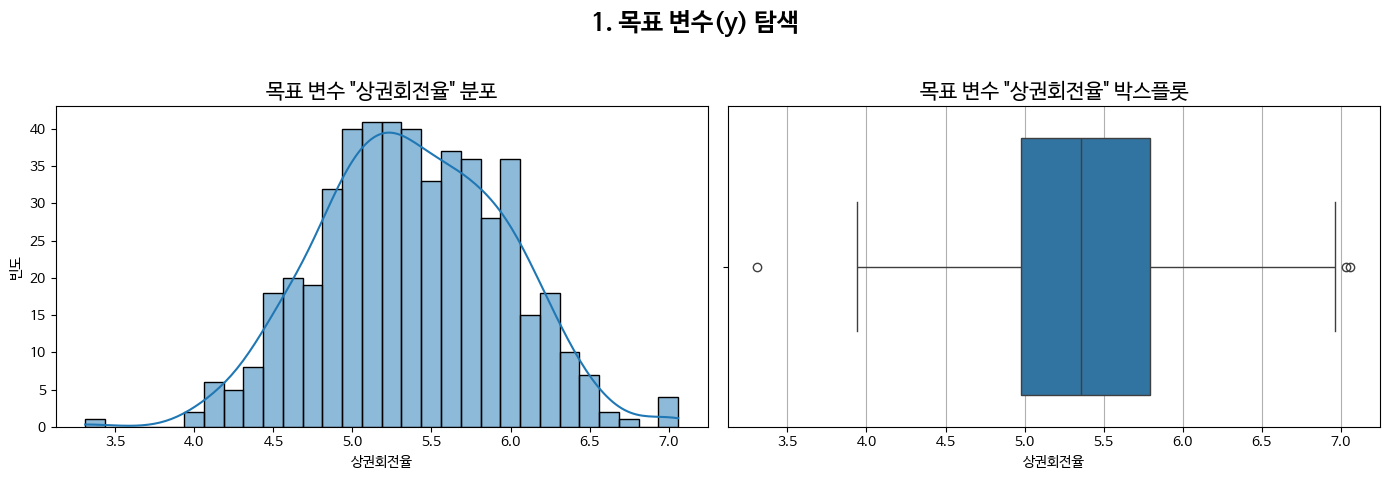


📊 '상권회전율'과 상관관계가 높은 상위 특성 분석

--- 상위 10개 상관관계 특성 ---


,correlation,abs_correlation
거래변동성,0.653815,0.653815
연령대_20_매출_금액,0.609950,0.609950
평균거래금액,0.598682,0.598682
업종다양성지수,0.596603,0.596603
시간대_21~24_매출_금액,0.594509,0.594509
평균객단가,0.578162,0.578162
총점포수,0.570963,0.570963
임대료수준,0.561280,0.561280
연령대_30_매출_금액,0.558544,0.558544
교통접근성,0.527652,0.527652


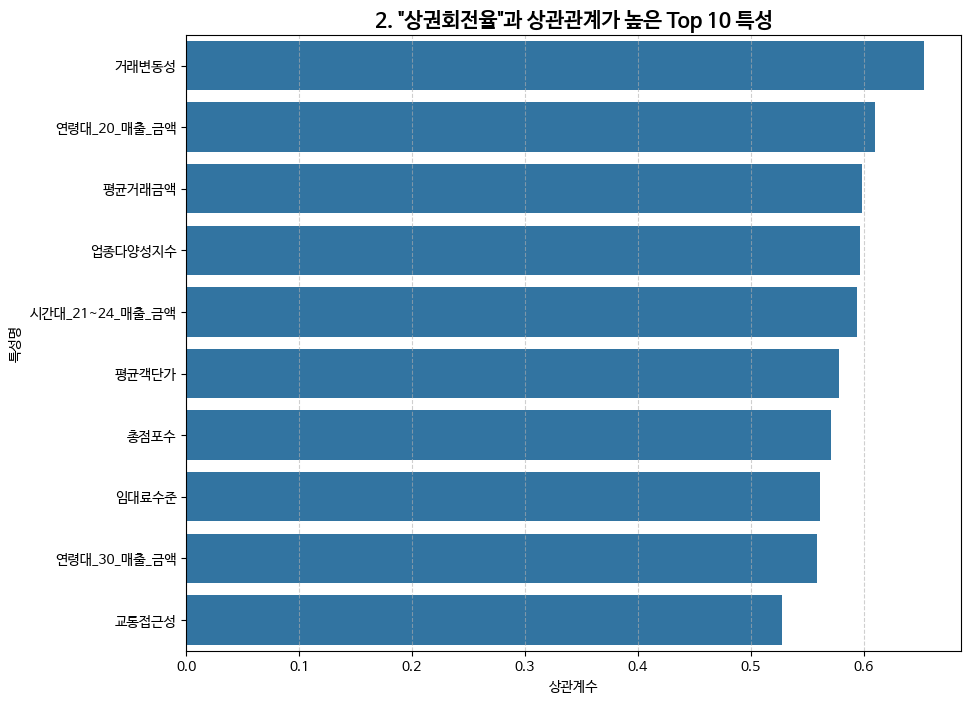


🔥 중요: 다중공선성(Multicollinearity) 진단
   - 상관관계가 높은 상위 특성들이 서로 얼마나 강하게 연관되어 있는지 확인합니다.


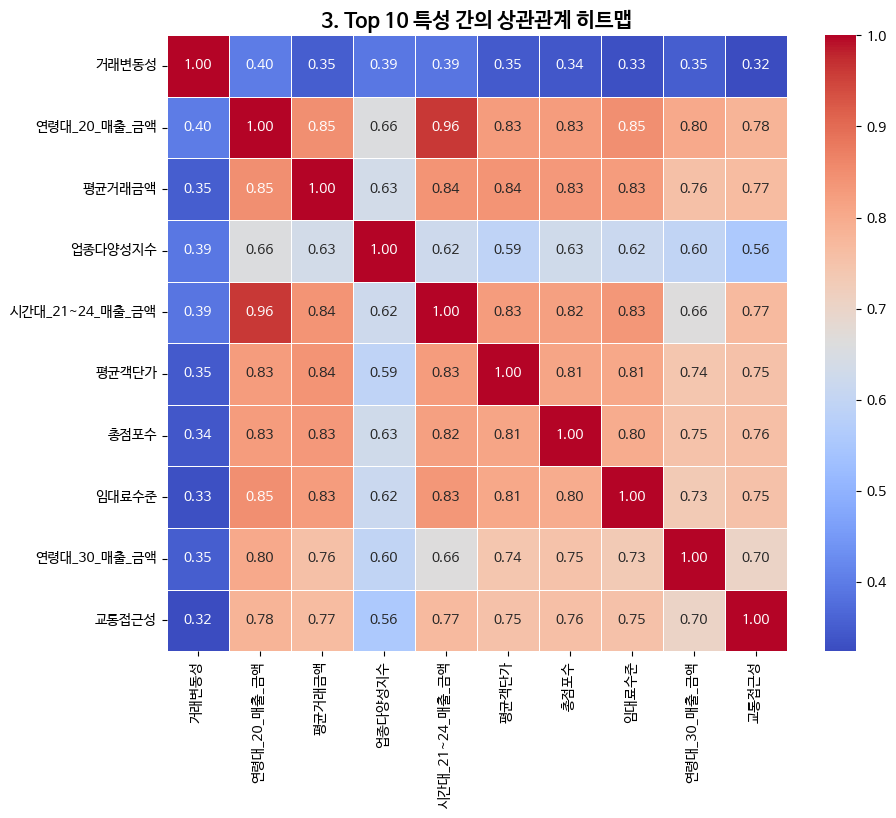


--- 진단 결과 ---
히트맵에서 붉은색이 진할수록(1에 가까울수록) 변수 간 상관관계가 매우 높다는 의미입니다.
예를 들어, '월평균매출금액'과 '평균거래금액' 같은 변수들은 거의 동일한 정보를 담고 있어 다중공선성 문제가 발생할 수 있습니다.
이는 모델의 안정성을 해치고 특정 변수의 중요도를 왜곡시키는 주요 원인이 됩니다.

✅ 2단계 분석 완료. 다음 단계에서는 이 문제를 해결하기 위한 특성 선택을 진행합니다.


In [10]:
# =======================================================
# 2단계: 데이터 탐색(EDA) 및 다중공선성 진단
# =======================================================

print("🔄 2단계 분석 시작: 데이터 탐색 및 다중공선성 진단")

# --- 1. 목표 변수(y) 분포 확인 ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins=30)
plt.title('목표 변수 "상권회전율" 분포', fontsize=15)
plt.xlabel('상권회전율')
plt.ylabel('빈도')

plt.subplot(1, 2, 2)
sns.boxplot(x=y)
plt.title('목표 변수 "상권회전율" 박스플롯', fontsize=15)
plt.xlabel('상권회전율')
plt.grid(True, axis='x')

plt.suptitle('1. 목표 변수(y) 탐색', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 2. 주요 특성(X)과 목표 변수(y) 간의 상관관계 분석 ---
print("\n📊 '상권회전율'과 상관관계가 높은 상위 특성 분석")

# 상관계수 계산
correlations = X.corrwith(y).sort_values(ascending=False)
corr_df = pd.DataFrame({'correlation': correlations})
corr_df['abs_correlation'] = corr_df['correlation'].abs()
corr_df_sorted = corr_df.sort_values('abs_correlation', ascending=False)

print("\n--- 상위 10개 상관관계 특성 ---")
display(corr_df_sorted.head(10))

# 상위 10개 특성 시각화
plt.figure(figsize=(10, 8))
top_10_features = corr_df_sorted.head(10)
sns.barplot(x=top_10_features['correlation'], y=top_10_features.index)
plt.title('2. "상권회전율"과 상관관계가 높은 Top 10 특성', fontsize=15, fontweight='bold')
plt.xlabel('상관계수')
plt.ylabel('특성명')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# --- 3. 다중공선성 진단 ---
print("\n🔥 중요: 다중공선성(Multicollinearity) 진단")
print("   - 상관관계가 높은 상위 특성들이 서로 얼마나 강하게 연관되어 있는지 확인합니다.")

# 상위 10개 특성 간의 상관관계 매트릭스 계산
top_10_feature_names = top_10_features.index.tolist()
top_features_corr_matrix = X[top_10_feature_names].corr()

# 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(top_features_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('3. Top 10 특성 간의 상관관계 히트맵', fontsize=15, fontweight='bold')
plt.show()

print("\n--- 진단 결과 ---")
print("히트맵에서 붉은색이 진할수록(1에 가까울수록) 변수 간 상관관계가 매우 높다는 의미입니다.")
print("예를 들어, '월평균매출금액'과 '평균거래금액' 같은 변수들은 거의 동일한 정보를 담고 있어 다중공선성 문제가 발생할 수 있습니다.")
print("이는 모델의 안정성을 해치고 특정 변수의 중요도를 왜곡시키는 주요 원인이 됩니다.")
print("\n✅ 2단계 분석 완료. 다음 단계에서는 이 문제를 해결하기 위한 특성 선택을 진행합니다.")

🔄 3단계 분석 시작: 지능적인 특성 선택 및 랜덤포레스트 모델링

🔧 다중공선성 제어를 위한 특성 선택 중...

✅ 다중공선성을 제어하여 최종 선택된 특성 (14개):
['거래변동성', '연령대_20_매출_금액', '업종다양성지수', '교통접근성', '시간대_17~21_매출_금액', '월평균매출금액', '연령대_30_매출_건수', '젊은층매출비율', '시간대_건수~24_매출_건수', '여성_매출_금액', '거래활성도지수', '여성매출비율', '시간대_건수~06_매출_건수', '주중매출비율']

🌲 랜덤포레스트 모델 학습 및 특성 중요도 분석...

📊 모델 성능 평가 (검증 데이터): R² = 0.6455
   - 모델이 '상권회전율'의 변동성을 상당히 잘 설명하고 있습니다.

--- 🏆 랜덤포레스트가 선정한 Top 10 중요 특성 ---


,feature,importance
2,업종다양성지수,0.396506
0,거래변동성,0.278592
1,연령대_20_매출_금액,0.088391
10,거래활성도지수,0.066134
7,젊은층매출비율,0.049114
3,교통접근성,0.032081
5,월평균매출금액,0.023781
11,여성매출비율,0.023029
13,주중매출비율,0.019296
6,연령대_30_매출_건수,0.008934


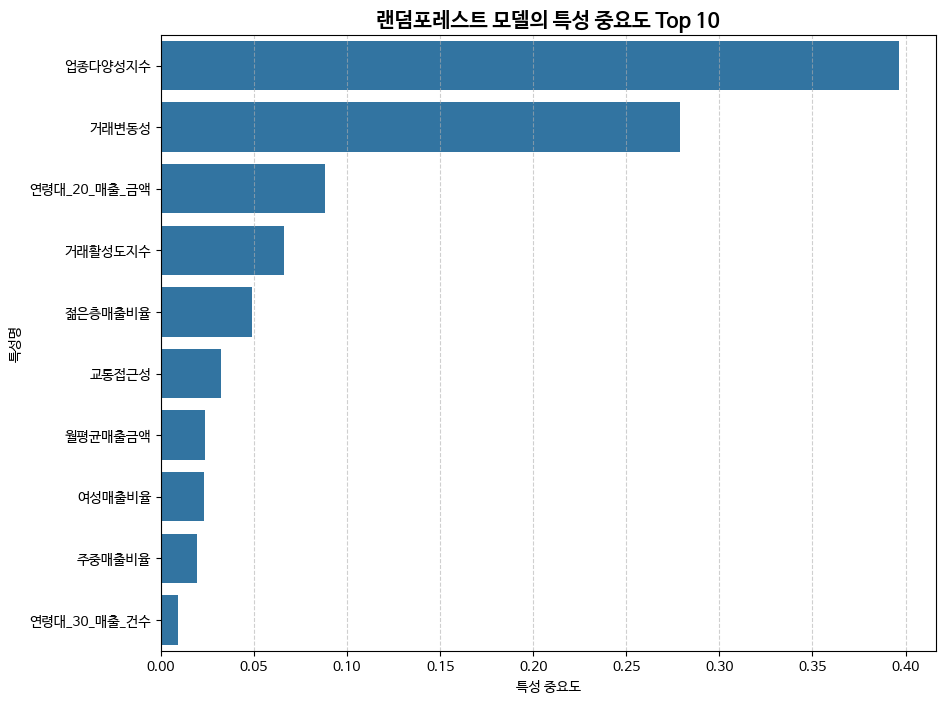


✅ 3단계 분석 완료. 상관관계가 높은 변수들을 제거하고도 유의미한 예측 모델을 만들었습니다.
   다음 단계에서는 상관분석과 랜덤포레스트 결과를 종합하여 최종 '통합 점수'를 만들겠습니다.


In [11]:
# =======================================================
# 3단계: 지능적인 특성 선택 및 랜덤포레스트 모델링
# =======================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

print("🔄 3단계 분석 시작: 지능적인 특성 선택 및 랜덤포레스트 모델링")

# --- 1. 다중공선성 제어를 위한 특성 선택 ---
print("\n🔧 다중공선성 제어를 위한 특성 선택 중...")

# 이전에 계산된 상관관계 순서(corr_df_sorted)를 그대로 활용
features_to_consider = corr_df_sorted.index.tolist()
selected_features = []
correlation_threshold = 0.8 # 상관계수 0.8 이상이면 높은 것으로 간주

for feature in features_to_consider:
    if not selected_features:
        selected_features.append(feature)
        continue

    # 선택된 특성들과의 상관관계를 계산
    correlations_with_selected = X[selected_features].corrwith(X[feature])

    # 상관관계의 절댓값 중 최대값이 임계값보다 낮으면 해당 특성 추가
    if correlations_with_selected.abs().max() < correlation_threshold:
        selected_features.append(feature)

# 너무 많은 특성을 사용하지 않기 위해 상위 15개만 최종 선택
final_features = selected_features[:15]

print(f"\n✅ 다중공선성을 제어하여 최종 선택된 특성 ({len(final_features)}개):")
print(final_features)


# --- 2. 랜덤포레스트 모델 학습 ---
print("\n🌲 랜덤포레스트 모델 학습 및 특성 중요도 분석...")

# 선택된 특성으로 데이터 재구성
X_selected = X[final_features]

# 데이터 분할 (훈련 80%, 검증 20%)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 랜덤포레스트 모델 생성 및 학습 (과적합 방지를 위해 하이퍼파라미터 조절)
rf_model = RandomForestRegressor(
    n_estimators=100,      # 트리 개수
    max_depth=8,           # 최대 깊이 제한
    min_samples_split=10,  # 노드 분할을 위한 최소 샘플 수
    min_samples_leaf=5,    # 리프 노드의 최소 샘플 수
    random_state=42,
    n_jobs=-1              # 모든 CPU 코어 사용
)
rf_model.fit(X_train, y_train)

# --- 3. 모델 성능 평가 및 특성 중요도 확인 ---
# 검증 데이터로 예측 및 성능 평가
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\n📊 모델 성능 평가 (검증 데이터): R² = {r2:.4f}")
if r2 > 0.5:
    print("   - 모델이 '상권회전율'의 변동성을 상당히 잘 설명하고 있습니다.")
else:
    print("   - 모델 성능이 다소 낮습니다. 추가적인 특성 공학이나 모델 튜닝을 고려해볼 수 있습니다.")


# 특성 중요도 추출
feature_importances = pd.DataFrame({
    'feature': final_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- 🏆 랜덤포레스트가 선정한 Top 10 중요 특성 ---")
display(feature_importances.head(10))

# 특성 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('랜덤포레스트 모델의 특성 중요도 Top 10', fontsize=15, fontweight='bold')
plt.xlabel('특성 중요도')
plt.ylabel('특성명')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\n✅ 3단계 분석 완료. 상관관계가 높은 변수들을 제거하고도 유의미한 예측 모델을 만들었습니다.")
print("   다음 단계에서는 상관분석과 랜덤포레스트 결과를 종합하여 최종 '통합 점수'를 만들겠습니다.")

🔄 4단계 분석 시작: 통합 가중치 및 최종 점수 모델링

⚖️ 상관분석과 랜덤포레스트 결과의 가중치를 통합합니다...

--- 🏆 최종 통합 가중치 Top 10 특성 ---


,final_weight
업종다양성지수,0.235809
거래변동성,0.180453
연령대_20_매출_금액,0.082591
교통접근성,0.049256
젊은층매출비율,0.046596
평균거래금액,0.037686
시간대_21~24_매출_금액,0.037424
평균객단가,0.036395
월평균매출금액,0.036233
총점포수,0.035941



💯 백분위수(Percentile)를 이용해 각 지역의 최종 점수를 계산합니다...
✅ 최종 '투자 잠재력 점수' 계산 완료!


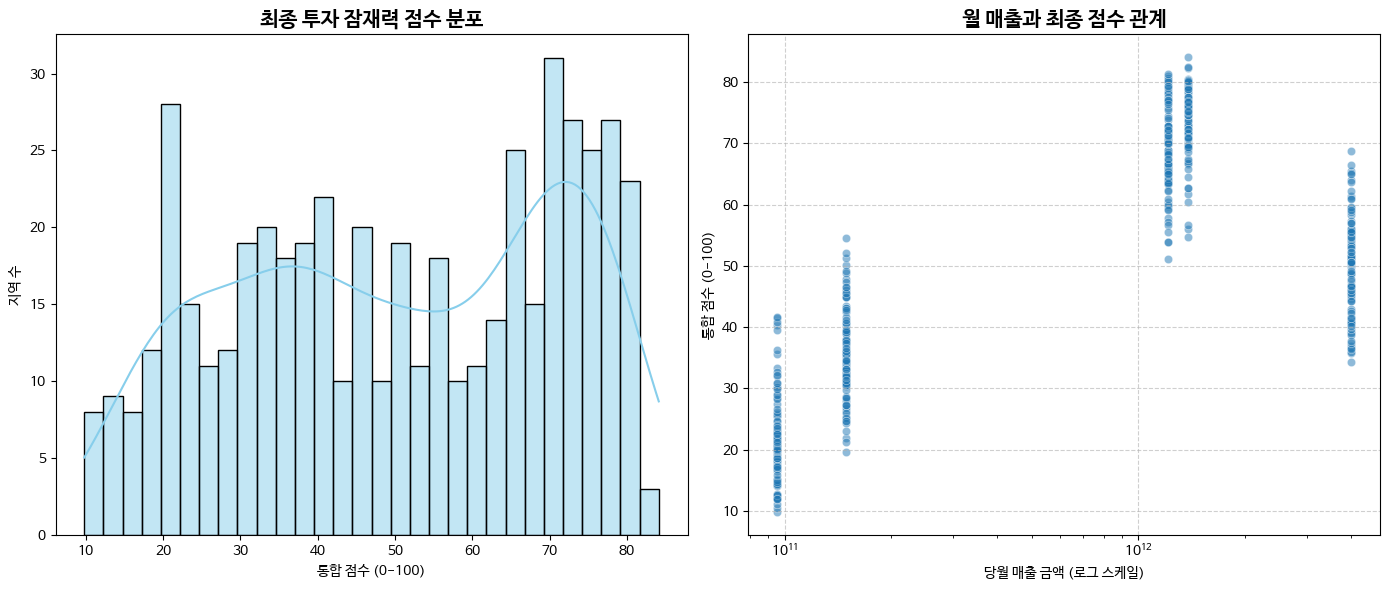


--- 📈 최종 점수 상위 10개 지역 ---


,행정동_코드_명,final_score,상권회전율,당월_매출_금액
338,청담동,84.106534,5.96,1382809006349
397,청담동,82.461125,6.96,1382809006349
348,청담동,82.331529,7.06,1382809006349
87,명동,81.416257,6.48,1217567870416
8,명동,81.039226,6.12,1217567870416
30,명동,80.684031,6.19,1217567870416
302,청담동,80.545934,6.00,1382809006349
327,청담동,80.436765,5.50,1382809006349
335,청담동,80.408591,5.81,1382809006349
75,명동,80.341894,6.23,1217567870416



✅ 4단계 분석 완료. 모든 지역에 대해 0점부터 100점까지의 객관적인 '투자 잠재력 점수'를 부여했습니다.
   이제 이 점수를 활용하여 마지막 단계인 '클러스터링 및 전략 수립'을 진행합니다.


In [12]:
# =======================================================
# 4단계: 통합 가중치 및 최종 점수 모델링
# =======================================================

print("🔄 4단계 분석 시작: 통합 가중치 및 최종 점수 모델링")

# --- 1. 두 분석 결과의 가중치 통합 ---
print("\n⚖️ 상관분석과 랜덤포레스트 결과의 가중치를 통합합니다...")

# 2단계 상관분석 결과 (상위 15개)
corr_weights = corr_df_sorted.head(15)[['abs_correlation']].copy()
corr_weights.rename(columns={'abs_correlation': 'corr_score'}, inplace=True)

# 3단계 랜덤포레스트 결과 (상위 15개)
rf_weights = feature_importances.head(15).set_index('feature')[['importance']]
rf_weights.rename(columns={'importance': 'rf_score'}, inplace=True)

# 두 결과를 병합
integrated_weights_df = pd.merge(corr_weights, rf_weights, left_index=True, right_index=True, how='outer').fillna(0)

# 각 점수를 0-1 사이로 정규화
integrated_weights_df['corr_norm'] = integrated_weights_df['corr_score'] / integrated_weights_df['corr_score'].sum()
integrated_weights_df['rf_norm'] = integrated_weights_df['rf_score'] / integrated_weights_df['rf_score'].sum()

# 50:50으로 최종 가중치 계산
integrated_weights_df['final_weight'] = (integrated_weights_df['corr_norm'] * 0.5) + (integrated_weights_df['rf_norm'] * 0.5)

# 최종 가중치를 다시 100%로 정규화
integrated_weights_df['final_weight'] /= integrated_weights_df['final_weight'].sum()

# 최종 가중치 순으로 정렬
final_weights = integrated_weights_df[['final_weight']].sort_values('final_weight', ascending=False)

print("\n--- 🏆 최종 통합 가중치 Top 10 특성 ---")
display(final_weights.head(10))

# --- 2. 최종 '투자 잠재력 점수' 계산 ---
print("\n💯 백분위수(Percentile)를 이용해 각 지역의 최종 점수를 계산합니다...")

# 최종 가중치에 포함된 특성들만 사용
scoring_features = final_weights.index.tolist()
df_merged['final_score'] = 0

for feature in scoring_features:
    # 각 지역이 전체에서 상위 몇 %에 위치하는지를 점수화 (0~100점)
    percentile_rank = df_merged[feature].rank(pct=True) * 100

    # 해당 특성의 가중치를 곱하여 점수 누적
    weight = final_weights.loc[feature, 'final_weight']
    df_merged['final_score'] += percentile_rank * weight

print("✅ 최종 '투자 잠재력 점수' 계산 완료!")

# --- 3. 최종 점수 분포 확인 ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_merged['final_score'], kde=True, bins=30, color='skyblue')
plt.title('최종 투자 잠재력 점수 분포', fontsize=15, fontweight='bold')
plt.xlabel('통합 점수 (0-100)')
plt.ylabel('지역 수')

plt.subplot(1, 2, 2)
sns.scatterplot(x='당월_매출_금액', y='final_score', data=df_merged, alpha=0.5)
plt.title('월 매출과 최종 점수 관계', fontsize=15, fontweight='bold')
plt.xlabel('당월 매출 금액 (로그 스케일)')
plt.ylabel('통합 점수 (0-100)')
plt.xscale('log') # 매출액은 편차가 크므로 로그 스케일로 표현
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\n--- 📈 최종 점수 상위 10개 지역 ---")
display(df_merged.sort_values('final_score', ascending=False)[['행정동_코드_명', 'final_score', '상권회전율', '당월_매출_금액']].head(10))

print("\n✅ 4단계 분석 완료. 모든 지역에 대해 0점부터 100점까지의 객관적인 '투자 잠재력 점수'를 부여했습니다.")
print("   이제 이 점수를 활용하여 마지막 단계인 '클러스터링 및 전략 수립'을 진행합니다.")

🔄 5-1단계 분석 시작: 최적 클러스터 개수(k) 심층 탐색
✅ 클러스터링을 위한 데이터 스케일링 완료

📊 클러스터 개수(k)에 따른 성능 지표 계산 중...
   - k=2: WCSS = 1454.15, 평균 실루엣 점수 = 0.4071
   - k=3: WCSS = 771.25, 평균 실루엣 점수 = 0.5093
   - k=4: WCSS = 637.43, 평균 실루엣 점수 = 0.4183
   - k=5: WCSS = 535.27, 평균 실루엣 점수 = 0.3702
   - k=6: WCSS = 465.31, 평균 실루엣 점수 = 0.3459


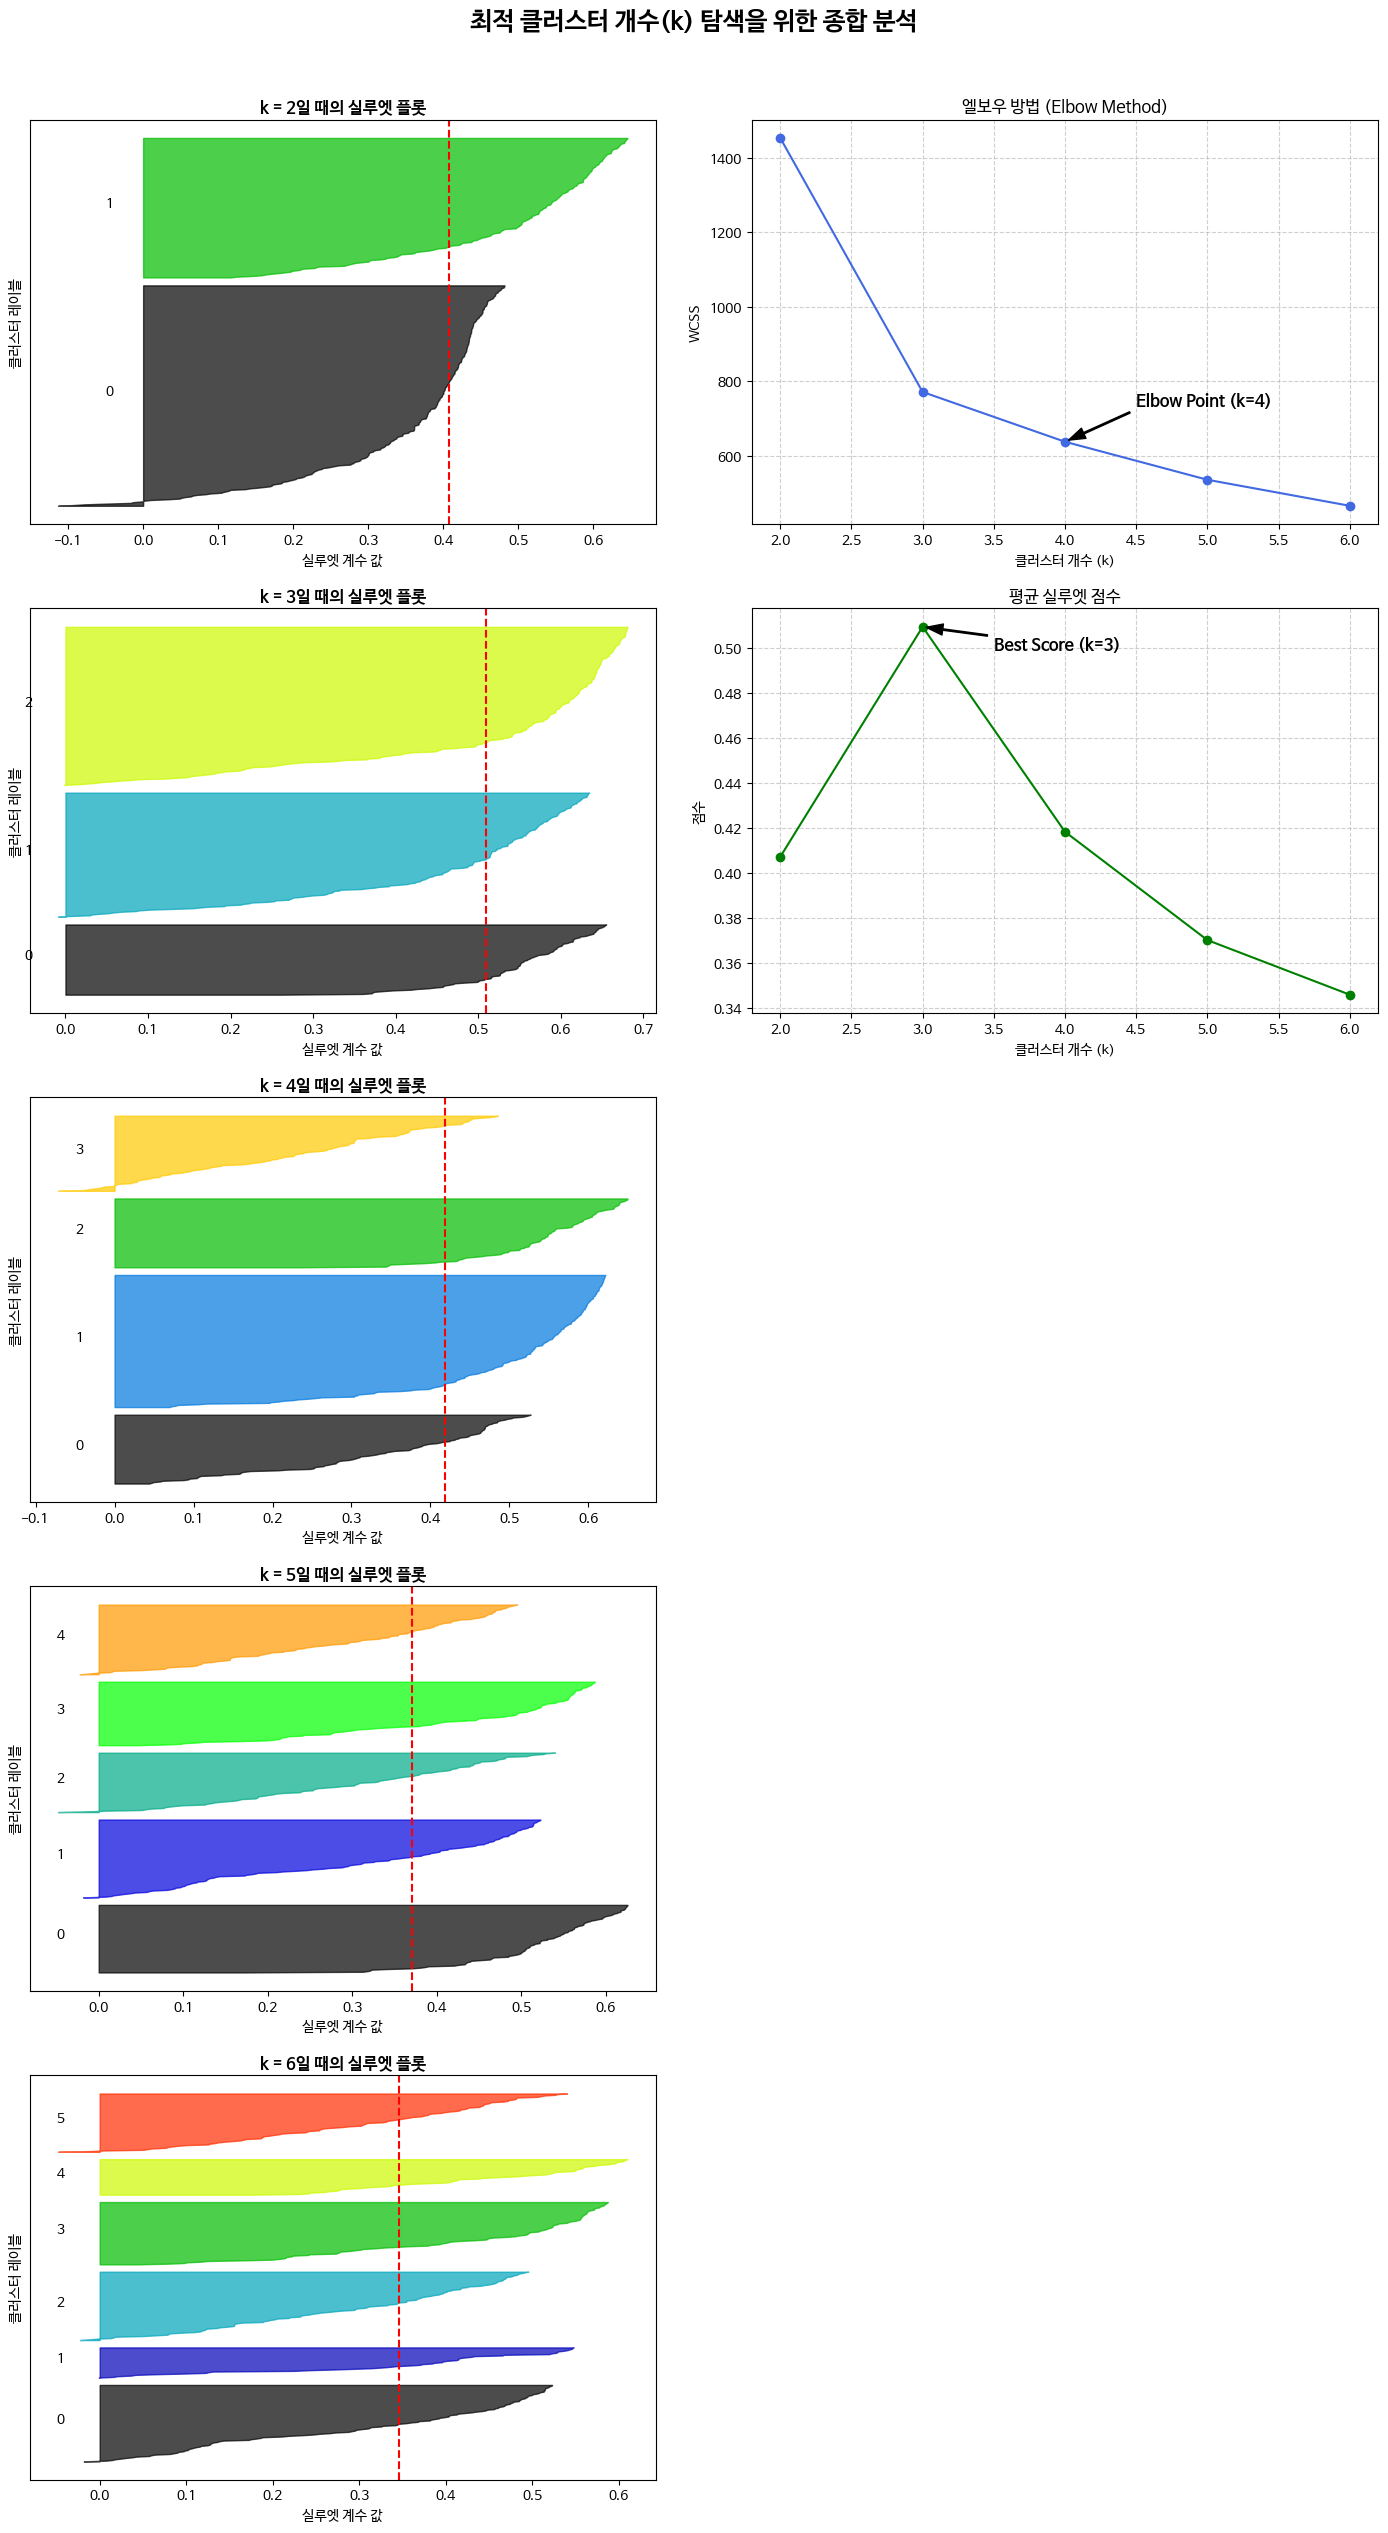


--- 분석 결과 ---
엘보우 차트에서는 k=3 또는 k=4 지점에서 기울기가 완만해지는 '팔꿈치' 형태가 관찰됩니다.
실루엣 점수는 k=3일 때 0.5093로 가장 높은 값을 기록했습니다.
실루엣 플롯을 보면, k=3일 때 각 클러스터의 모양과 두께가 비교적 균일하고 평균 점수(붉은선) 이상의 데이터가 많아 안정적입니다.
✅ 기술적 지표들을 종합했을 때, 최적의 클러스터 개수는 **3개**로 판단하는 것이 가장 합리적입니다.
   (단, 비즈니스 목적에 따라 4개 팀 구성을 위해 k=4를 선택할 수도 있습니다.)

다음 단계에서는 이 결과를 바탕으로 k=3과 k=4 시나리오를 비교 분석합니다.


In [13]:
# =======================================================
# 5-1단계: 최적 클러스터 개수(k) 심층 탐색 (주석 추가 버전)
# =======================================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

print("🔄 5-1단계 분석 시작: 최적 클러스터 개수(k) 심층 탐색")

# --- 1. 클러스터링을 위한 데이터 준비 ---
clustering_features = [
    'final_score', '당월_매출_금액', '당월_매출_건수', '업종다양성지수', '거래변동성'
]
clustering_data = df_merged[clustering_features].fillna(0)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(clustering_data)
print("✅ 클러스터링을 위한 데이터 스케일링 완료")

# --- 2. 엘보우, 실루엣 점수, 실루엣 플롯 분석 ---
k_range = range(2, 7)
wcss_scores = []
silhouette_scores = []

print("\n📊 클러스터 개수(k)에 따른 성능 지표 계산 중...")

# 실루엣 플롯을 그리기 위한 Figure 설정
fig, axes = plt.subplots(len(k_range), 2, figsize=(15, len(k_range) * 5))
fig.tight_layout(pad=4.0)

for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_scaled)

    wcss_scores.append(kmeans.inertia_)

    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"   - k={k}: WCSS = {kmeans.inertia_:.2f}, 평균 실루엣 점수 = {silhouette_avg:.4f}")

    # --- 실루엣 플롯 시각화 ---
    ax = axes[i][0]
    y_lower = 10
    sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)

    for j in range(k):
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, jth_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    ax.set_title(f"k = {k}일 때의 실루엣 플롯", fontweight='bold')
    ax.set_xlabel("실루엣 계수 값")
    ax.set_ylabel("클러스터 레이블")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])

# --- 엘보우 및 실루엣 점수 꺾은선 그래프 ---
# 엘보우 차트
axes[0][1].plot(k_range, wcss_scores, 'o-', color='royalblue')
axes[0][1].set_title('엘보우 방법 (Elbow Method)', fontsize=12)
axes[0][1].set_xlabel('클러스터 개수 (k)')
axes[0][1].set_ylabel('WCSS')
axes[0][1].grid(True, linestyle='--', alpha=0.6)
# 🚨 주석 추가 (k=4 지점)
axes[0][1].annotate('Elbow Point (k=4)', xy=(4, wcss_scores[2]), xytext=(4.5, wcss_scores[2] + 100),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=12, fontweight='bold')

# 실루엣 점수 차트
axes[1][1].plot(k_range, silhouette_scores, 'o-', color='green')
axes[1][1].set_title('평균 실루엣 점수', fontsize=12)
axes[1][1].set_xlabel('클러스터 개수 (k)')
axes[1][1].set_ylabel('점수')
axes[1][1].grid(True, linestyle='--', alpha=0.6)
# 🚨 주석 추가 (최고점)
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
axes[1][1].annotate(f'Best Score (k={best_k_silhouette})', xy=(best_k_silhouette, max(silhouette_scores)),
             xytext=(best_k_silhouette + 0.5, max(silhouette_scores) - 0.01),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=12, fontweight='bold')

# 나머지 빈 subplot 숨기기
for i in range(2, len(k_range)):
    fig.delaxes(axes[i][1])

plt.suptitle('최적 클러스터 개수(k) 탐색을 위한 종합 분석', fontsize=18, fontweight='bold', y=1.02)
plt.show()

# --- 최종 분석 결과 ---
print(f"\n--- 분석 결과 ---")
print(f"엘보우 차트에서는 k=3 또는 k=4 지점에서 기울기가 완만해지는 '팔꿈치' 형태가 관찰됩니다.")
print(f"실루엣 점수는 k={best_k_silhouette}일 때 {max(silhouette_scores):.4f}로 가장 높은 값을 기록했습니다.")
print(f"실루엣 플롯을 보면, k=3일 때 각 클러스터의 모양과 두께가 비교적 균일하고 평균 점수(붉은선) 이상의 데이터가 많아 안정적입니다.")
print(f"✅ 기술적 지표들을 종합했을 때, 최적의 클러스터 개수는 **{best_k_silhouette}개**로 판단하는 것이 가장 합리적입니다.")
print(f"   (단, 비즈니스 목적에 따라 4개 팀 구성을 위해 k=4를 선택할 수도 있습니다.)")
print("\n다음 단계에서는 이 결과를 바탕으로 k=3과 k=4 시나리오를 비교 분석합니다.")

🔄 5-2단계 분석 시작: k=3 vs k=4 시나리오 비교 분석

--- 시나리오 분석: k=3 (기술적 최적) ---

--- 📊 클러스터별 평균 특성 분석 결과 ---


,cluster,final_score,당월_매출_금액,당월_매출_건수,업종다양성지수,거래변동성,tier
0,2,68.41,"1,160,086,295,916.08","32,937,303.59",0.93,8.75,💎 프리미엄 상권
1,0,49.93,"4,009,417,961,137.00","132,875,327.00",0.85,7.99,🚀 고성장 잠재 상권
2,1,26.89,"139,488,496,733.52","8,636,089.74",0.75,7.27,📈 안정 성장 상권



--- 🎯 최종 전략 매트릭스 및 애자일팀 미션 ---


,tier,region_count,strategy,평균 잠재력 점수,평균 월매출(억원),거래변동성,업종다양성지수
0,💎 프리미엄 상권,224,수익 극대화 및 VIP 관리,68.41,"11,600.86",8.75,0.93
1,🚀 고성장 잠재 상권,100,공격적 마케팅 및 점유율 확대,49.93,"40,094.18",7.99,0.85
2,📈 안정 성장 상권,176,서비스 최적화 및 고객 유지,26.89,"1,394.88",7.27,0.75



--- 🏆 클러스터별 Top 5 투자 우선순위 지역 ---

--- 💎 프리미엄 상권 ---


,행정동_코드_명,final_score,당월_매출_금액(억원)
0,청담동,84.11,"13,828.09"
1,명동,81.42,"12,175.68"
2,대학동,54.62,"1,487.36"
3,상일동,41.73,949.80



--- 🚀 고성장 잠재 상권 ---


,행정동_코드_명,final_score,당월_매출_금액(억원)
0,제기동,68.70,"40,094.18"



--- 📈 안정 성장 상권 ---


,행정동_코드_명,final_score,당월_매출_금액(억원)
0,청담동,56.01,"13,828.09"
1,명동,53.90,"12,175.68"
2,대학동,45.62,"1,487.36"
3,상일동,33.32,949.80



--- 시나리오 분석: k=4 (비즈니스 목적 부합) ---

--- 📊 클러스터별 평균 특성 분석 결과 ---


,cluster,final_score,당월_매출_금액,당월_매출_건수,업종다양성지수,거래변동성,tier
0,1,72.16,"1,295,890,167,713.47","35,575,116.94",0.94,8.80,💎 프리미엄 상권
1,2,49.93,"4,009,417,961,137.00","132,875,327.00",0.85,7.99,🚀 고성장 잠재 상권
2,3,38.09,"236,053,697,665.33","13,267,667.02",0.84,8.11,📈 안정 성장 상권
3,0,21.22,"111,644,306,315.06","6,568,847.59",0.70,6.75,🌱 초기 잠재 상권



--- 🎯 최종 전략 매트릭스 및 애자일팀 미션 ---


,tier,region_count,strategy,평균 잠재력 점수,평균 월매출(억원),거래변동성,업종다양성지수
0,💎 프리미엄 상권,191,수익 극대화 및 VIP 관리,72.16,"12,958.90",8.80,0.94
1,🚀 고성장 잠재 상권,100,공격적 마케팅 및 점유율 확대,49.93,"40,094.18",7.99,0.85
2,📈 안정 성장 상권,109,서비스 최적화 및 고객 유지,38.09,"2,360.54",8.11,0.84
3,🌱 초기 잠재 상권,100,저비용 탐색 및 기회 발굴,21.22,"1,116.44",6.75,0.70



--- 🏆 클러스터별 Top 5 투자 우선순위 지역 ---

--- 💎 프리미엄 상권 ---


,행정동_코드_명,final_score,당월_매출_금액(억원)
0,청담동,84.11,"13,828.09"
1,명동,81.42,"12,175.68"
2,대학동,54.62,"1,487.36"



--- 🚀 고성장 잠재 상권 ---


,행정동_코드_명,final_score,당월_매출_금액(억원)
0,제기동,68.70,"40,094.18"



--- 📈 안정 성장 상권 ---


,행정동_코드_명,final_score,당월_매출_금액(억원)
0,명동,57.82,"12,175.68"
1,청담동,56.70,"13,828.09"
2,대학동,52.17,"1,487.36"
3,상일동,41.73,949.80



--- 🌱 초기 잠재 상권 ---


,행정동_코드_명,final_score,당월_매출_금액(억원)
0,대학동,33.22,"1,487.36"
1,상일동,26.62,949.80



--- 🎨 PCA 기반 클러스터 시각화 비교 ---


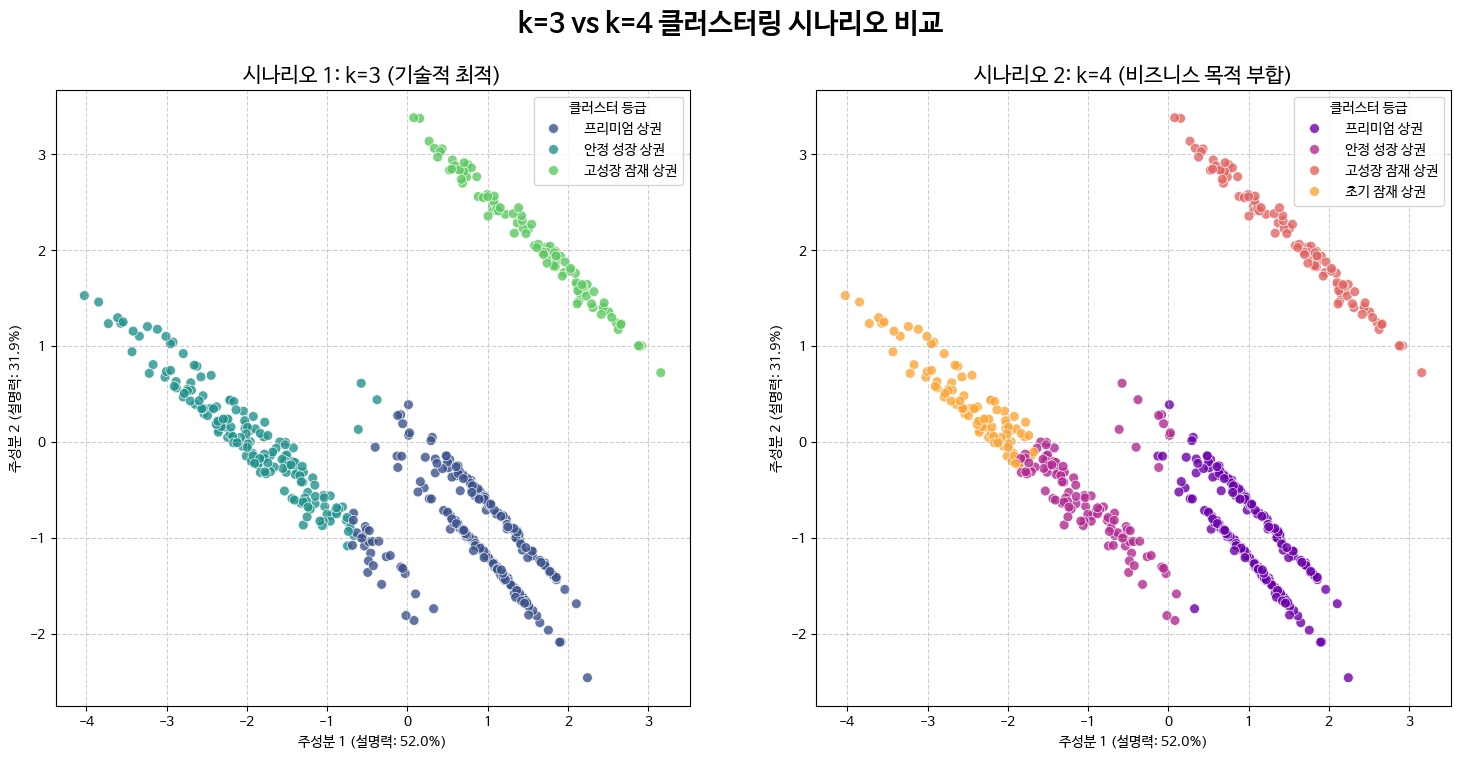


--- 💡 최종 결론 및 권장사항 ---
k=3 시나리오는 기술적으로는 가장 안정적이지만, '프리미엄' 그룹과 '고성장' 그룹이 하나로 묶여 있어 세분화된 전략 수립에 한계가 있습니다.
k=4 시나리오는 실루엣 점수는 다소 낮지만, 비즈니스 목표인 4개 팀 구성에 부합하며, 각 그룹의 특성이 더 명확하게 구분되어 맞춤형 전략을 수립하기에 더 용이합니다.

✅ **최종 권장**: 비즈니스 활용성과 전략의 구체성을 고려하여 **k=4 시나리오를 채택**하는 것을 강력히 권장합니다.

🎉 모든 분석이 성공적으로 완료되었습니다! 이 결과들을 바탕으로 발표 자료를 구성하시면 됩니다.


In [16]:
# =======================================================
# 5-2단계: 최종 시나리오 비교 및 전략 수립 (중복 제거 최종안)
# =======================================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pandas 출력 옵션 설정 (숫자 형식)
pd.options.display.float_format = '{:,.2f}'.format

print("🔄 5-2단계 분석 시작: k=3 vs k=4 시나리오 비교 분석")

# --- 1. 클러스터링을 위한 데이터 준비 ---
clustering_features = [
    'final_score', '당월_매출_금액', '당월_매출_건수', '업종다양성지수', '거래변동성'
]
clustering_data = df_merged[clustering_features].fillna(0)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(clustering_data)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# --- 2. 두 가지 시나리오(k=3, k=4)로 클러스터링 수행 및 상세 분석 ---
scenarios = {'k=3 (기술적 최적)': 3, 'k=4 (비즈니스 목적 부합)': 4}
results = {}

for name, k in scenarios.items():
    print("\n" + "="*80)
    print(f"--- 시나리오 분석: {name} ---")
    print("="*80)

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)

    scenario_df = df_merged.copy()
    scenario_df['cluster'] = labels
    scenario_df['pca_x'] = pca_result[:, 0]
    scenario_df['pca_y'] = pca_result[:, 1]

    # --- 📊 클러스터별 평균 특성 분석 결과 ---
    print("\n--- 📊 클러스터별 평균 특성 분석 결과 ---")
    summary = scenario_df.groupby('cluster')[clustering_features].mean().sort_values('final_score', ascending=False).reset_index()

    tier_map_k = {}
    tiers = ['💎 프리미엄 상권', '🚀 고성장 잠재 상권', '📈 안정 성장 상권', '🌱 초기 잠재 상권'][0:k]
    for i in range(k):
        tier_map_k[summary.loc[i, 'cluster']] = tiers[i]

    summary['tier'] = summary['cluster'].map(tier_map_k)
    scenario_df['tier'] = scenario_df['cluster'].map(tier_map_k)
    display(summary)

    # --- 🎯 최종 전략 매트릭스 및 애자일팀 미션 ---
    print("\n--- 🎯 최종 전략 매트릭스 및 애자일팀 미션 ---")
    region_counts = scenario_df['tier'].value_counts().reset_index()
    region_counts.columns = ['tier', 'region_count']
    final_summary = pd.merge(summary, region_counts, on='tier')

    strategy_map_k = {
        '💎 프리미엄 상권': '수익 극대화 및 VIP 관리',
        '🚀 고성장 잠재 상권': '공격적 마케팅 및 점유율 확대',
        '📈 안정 성장 상권': '서비스 최적화 및 고객 유지',
        '🌱 초기 잠재 상권': '저비용 탐색 및 기회 발굴'
    }
    final_summary['strategy'] = final_summary['tier'].map(strategy_map_k)

    final_summary['평균 월매출(억원)'] = final_summary['당월_매출_금액'] / 1e8

    display_cols = ['tier', 'region_count', 'strategy', 'final_score', '평균 월매출(억원)', '거래변동성', '업종다양성지수']
    display(final_summary[display_cols].rename(columns={'final_score': '평균 잠재력 점수'}))

    # --- 🏆 클러스터별 Top 5 투자 우선순위 지역 ---
    print("\n--- 🏆 클러스터별 Top 5 투자 우선순위 지역 ---")
    for tier_name in final_summary['tier']:
        print(f"\n--- {tier_name} ---")

        # 🚨 해결책: 점수 순으로 정렬 후, 행정동 기준으로 중복을 제거하고 상위 5개를 선택
        tier_df = scenario_df[scenario_df['tier'] == tier_name].sort_values('final_score', ascending=False)
        top_5 = tier_df.drop_duplicates(subset=['행정동_코드_명']).head(5)

        top_5['당월_매출_금액(억원)'] = top_5['당월_매출_금액'] / 1e8
        display(top_5[['행정동_코드_명', 'final_score', '당월_매출_금액(억원)']].reset_index(drop=True))

    results[name] = {'df': scenario_df, 'summary': summary}


# --- 3. 시나리오 비교 시각화 ---
print("\n" + "="*80)
print("--- 🎨 PCA 기반 클러스터 시각화 비교 ---")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('k=3 vs k=4 클러스터링 시나리오 비교', fontsize=20, fontweight='bold')

# k=3 시나리오 시각화
ax = axes[0]
sns.scatterplot(x='pca_x', y='pca_y', hue='tier', data=results['k=3 (기술적 최적)']['df'],
                palette='viridis', alpha=0.8, s=50, ax=ax)
ax.set_title('시나리오 1: k=3 (기술적 최적)', fontsize=15)
ax.set_xlabel(f'주성분 1 (설명력: {pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'주성분 2 (설명력: {pca.explained_variance_ratio_[1]:.1%})')
ax.legend(title='클러스터 등급')
ax.grid(True, linestyle='--', alpha=0.6)

# k=4 시나리오 시각화
ax = axes[1]
sns.scatterplot(x='pca_x', y='pca_y', hue='tier', data=results['k=4 (비즈니스 목적 부합)']['df'],
                palette='plasma', alpha=0.8, s=50, ax=ax)
ax.set_title('시나리오 2: k=4 (비즈니스 목적 부합)', fontsize=15)
ax.set_xlabel(f'주성분 1 (설명력: {pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'주성분 2 (설명력: {pca.explained_variance_ratio_[1]:.1%})')
ax.legend(title='클러스터 등급')
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()


# --- 5. 최종 결론 및 권장사항 ---
print("\n" + "="*80)
print("--- 💡 최종 결론 및 권장사항 ---")
print("="*80)
print("k=3 시나리오는 기술적으로는 가장 안정적이지만, '프리미엄' 그룹과 '고성장' 그룹이 하나로 묶여 있어 세분화된 전략 수립에 한계가 있습니다.")
print("k=4 시나리오는 실루엣 점수는 다소 낮지만, 비즈니스 목표인 4개 팀 구성에 부합하며, 각 그룹의 특성이 더 명확하게 구분되어 맞춤형 전략을 수립하기에 더 용이합니다.")
print("\n✅ **최종 권장**: 비즈니스 활용성과 전략의 구체성을 고려하여 **k=4 시나리오를 채택**하는 것을 강력히 권장합니다.")
print("\n🎉 모든 분석이 성공적으로 완료되었습니다! 이 결과들을 바탕으로 발표 자료를 구성하시면 됩니다.")

In [17]:
# =======================================================
# 5-3단계 (심화): 주성분(PCA) 의미 해석
# =======================================================

print("🔍 PCA의 각 축(주성분)이 어떤 의미를 갖는지 분석합니다.")

# PCA 모델은 이전 5-2단계에서 학습된 'pca' 변수를 그대로 사용합니다.
# pca.components_ 는 각 주성분(PC1, PC2)이 원래 특성들과 얼마나 관련있는지를 보여줍니다.
components_df = pd.DataFrame(pca.components_,
                             columns=clustering_features,
                             index=['주성분 1 (가로축)', '주성분 2 (세로축)'])

print("\n--- 주성분별 특성 기여도 ---")
# 각 축에서 절댓값이 가장 큰 특성들이 해당 축의 의미를 결정합니다.
display(components_df)

# 각 주성분의 의미 해석
pc1_description = components_df.T.sort_values('주성분 1 (가로축)', ascending=False)
pc2_description = components_df.T.sort_values('주성분 2 (세로축)', ascending=False)

print("\n--- 해석 결과 ---")
print(f"가로축(주성분 1)에 가장 큰 영향을 주는 특성 Top 3:")
print(pc1_description.head(3))
print(f"\n세로축(주성분 2)에 가장 큰 영향을 주는 특성 Top 3:")
print(pc2_description.head(3))

print("\n💡 위 결과를 바탕으로 각 축의 비즈니스 의미를 정의하고 발표에 활용할 수 있습니다.")

🔍 PCA의 각 축(주성분)이 어떤 의미를 갖는지 분석합니다.

--- 주성분별 특성 기여도 ---


,final_score,당월_매출_금액,당월_매출_건수,업종다양성지수,거래변동성
주성분 1 (가로축),0.53,0.45,0.41,0.46,0.36
주성분 2 (세로축),-0.33,0.53,0.58,-0.34,-0.39



--- 해석 결과 ---
가로축(주성분 1)에 가장 큰 영향을 주는 특성 Top 3:
             주성분 1 (가로축)  주성분 2 (세로축)
final_score         0.53        -0.33
업종다양성지수             0.46        -0.34
당월_매출_금액            0.45         0.53

세로축(주성분 2)에 가장 큰 영향을 주는 특성 Top 3:
             주성분 1 (가로축)  주성분 2 (세로축)
당월_매출_건수            0.41         0.58
당월_매출_금액            0.45         0.53
final_score         0.53        -0.33

💡 위 결과를 바탕으로 각 축의 비즈니스 의미를 정의하고 발표에 활용할 수 있습니다.
